# Problem 1 (60 points)

While drilling and logging a highly deviated well in the direction of $S_{Hmax}$, you begin to notice breakouts in excess of $30^{\circ}$.  Wanting to take an extremely conservative approach you decided to adjust the trajectory of the well as you are already drilling with a mud weight close to the frac gradient (i.e., stabilizing the well with increased mud weight will lead to drilling induced tensile fractures and lost circulation).  What could you do to prevent breakouts in excess of $30^{\circ}$?  Support your recommendation with an explaination and figures.

Below are the reservior characteristics.  You can assume a Mohr-Coloumb failure criterion with an unconfined compressive strength of the rock of $34$ MPa and an internal friction of $\mu_I = 1$.  The Poisson ratio is $\nu = 0.2$.

$S_{Hmax} = 145$ MPa in the direction N$30^\circ$E

$S_{hmin} = 125$ MPa

$S_{v} = 70$ MPa

$P_p = P_m = 33$ MPa

**Solution**

First we will define the functions we need for all of the operations.

In [1]:
import numpy as np


def compute_Sg(S, angles=(0,0,0)):
    
    alpha, beta, gamma = np.radians(angles)
    
    Rg = np.array([[np.cos(alpha) * np.cos(beta),  
                    np.sin(alpha) * np.cos(beta),  
                    -np.sin(beta)],
                   [np.cos(alpha) * np.sin(beta) * np.sin(gamma) - np.sin(alpha) * np.cos(gamma), 
                    np.sin(alpha) * np.sin(beta) * np.sin(gamma) + np.cos(alpha) * np.cos(gamma),  
                    np.cos(beta) * np.sin(gamma)],
                   [np.cos(alpha) * np.sin(beta) * np.cos(gamma) + np.sin(alpha) * np.sin(gamma), 
                    np.sin(alpha) * np.sin(beta) * np.cos(gamma) - np.cos(alpha) * np.sin(gamma),  
                    np.cos(beta) * np.cos(gamma)]])
                  
    return np.dot(Rg.T, np.dot(S,Rg))


def compute_Sb(S, angles_G=(0,0,0), angles_B=(0,0)):
    
    delta, phi = np.radians(angles_B)
    
    Rb = np.array([[ np.cos(delta) * np.cos(phi),  np.sin(delta) * np.cos(phi), -np.sin(phi)],
                   [ -np.sin(delta), np.cos(delta),  0.0],
                   [ np.cos(delta) * np.sin(phi), np.sin(delta) * np.sin(phi), np.cos(phi)]])
    
    Sg = compute_Sg(S, angles_G)
    
    return np.dot(Rb, np.dot(Sg,Rb.T))


def compute_wellbore_stress(S, nu, theta, DP):
    
    theta = np.radians(theta)
    
    sZZ = (S[2,2] -  2. * nu * (S[0,0] - S[1,1]) * np.cos(2 * theta) - 
           4. * nu * S[0,1] * np.sin(2 * theta))
    
    stt = (S[0,0] + S[1,1] - 2. * (S[0,0] - S[1,1]) * np.cos(2 * theta) - 
           4 * S[0,1] * np.sin(2. * theta) - DP)
    
    ttz = 2. * (S[1,2] * np.cos(theta) - S[0,2] * np.sin(theta))
    
    srr = DP
    
    return (sZZ, stt, ttz, srr)


def compute_max_tangent_stress(S, nu, theta, DP):
    
    sZZ, stt, ttz, srr = compute_wellbore_stress(S, nu, theta, DP)
    
    return 0.5 * (sZZ + stt + np.sqrt((sZZ - stt) ** 2. + 4.0 * ttz ** 2.))


def compute_min_tangent_stress(S, nu, theta, DP):
    
    sZZ, stt, ttz, srr = compute_wellbore_stress(S, nu, theta, DP)
    
    return 0.5 * (sZZ + stt - np.sqrt((sZZ - stt) ** 2. + 4.0 * ttz ** 2.))


def compute_breakout_width(S, Pp, Pm, nu, C0, mu, angles_G=(0,0,0), angles_B=(0,0)):
    
    Sb = compute_Sb(S, angles_G, angles_B)
    
    Sb_eff = Sb - Pp * np.eye(3)
    
    theta = np.linspace(0, 360, num=90)
    
    smax = np.array([ compute_max_tangent_stress(Sb_eff, nu, i, (Pm-Pp)) for i in theta])
    smin = np.array([ compute_min_tangent_stress(Sb_eff, nu, i, (Pm-Pp)) for i in theta])
    DP_arr = np.ones_like(smin) * (Pm-Pp)
    
    sigma1 = (np.array([smax, smin, DP_arr]).T).max(axis=1)
    sigma3 = (np.array([smax, smin, DP_arr]).T).min(axis=1)
    
    breakout_bool_array = C0 < (sigma1) - ( np.sqrt(mu ** 2 + 1) + mu ) ** 2. * (sigma3)
    
    return np.round(breakout_bool_array.sum() * 2.0)

In [2]:
S = np.array([[145, 0, 0],[0,125,0],[0,0,70]])

delta = np.linspace(0, 360, num=50)
phi = np.linspace(0, 90, num=50)

res = np.array([ (np.cos(np.radians(d))*np.sin(np.radians(p)), 
                  np.sin(np.radians(d))*np.sin(np.radians(p)), 
                  compute_breakout_width(S, 33, 33, 0.2, 145, 1.0, angles_G=(30,0,0), angles_B=(d,p))) 
                  for d in delta for p in phi])

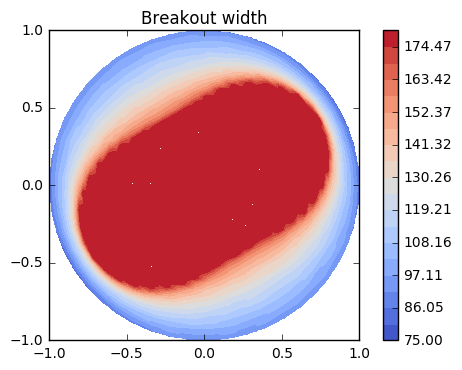

In [3]:
import scipy.interpolate
import matplotlib.pyplot as plt
%matplotlib inline

x = np.linspace(-1,1, num=500)
y = np.linspace(-1,1, num=500)
grid_x, grid_y = np.meshgrid(x,y)

X = res[:,0]
Y = res[:,1]
disp_x = scipy.interpolate.griddata((X, Y), res[:,2], (grid_x, grid_y), method='linear')
plt.figure()
plt.gca().set_aspect('equal')
plt.contourf(grid_x, grid_y, disp_x, cmap="coolwarm",levels=np.linspace(75,180,20))
plt.colorbar();
plt.title("Breakout width");

In this case, the recommentation would be to deviate the well more, as near horizontal as possible, otherwise one will have to set additional casing for near vertical wells to avoid problems with washouts.

## Extra test cases

In [4]:
S = np.array([[50, -5, 0],[-5, 40, 0],[0, 0, 43]]);
compute_Sb(S,(0,0,0),(30,45))

array([[ 43.08493649,  -4.82962913,   0.08493649],
       [ -4.82962913,  46.83012702,  -4.82962913],
       [  0.08493649,  -4.82962913,  43.08493649]])

In [5]:
compute_wellbore_stress(S, 0.2, 30, 0.0)

(44.464101615137757, 97.320508075688764, 0.0, 0.0)

In [6]:
compute_max_tangent_stress(S, 0.2, 30, 0.0)

97.320508075688764

In [7]:
compute_min_tangent_stress(S, 0.2, 30, 0.0)

44.464101615137764